## Logistic Regression

In [2]:
import theano.tensor as tt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
%matplotlib inline
palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Text(0, 0.5, '$logistic(z)$')

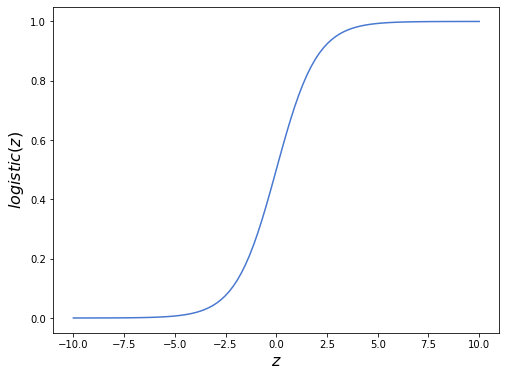

In [3]:
plt.figure(figsize=(8, 6))
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)

In [4]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='species', ylabel='sepal_length'>

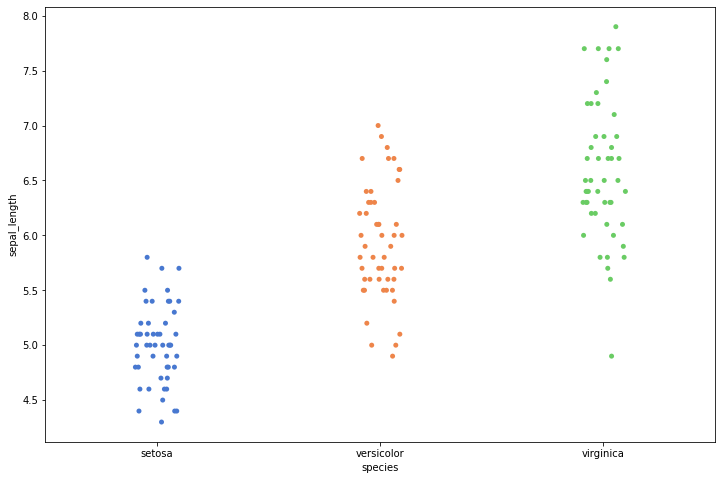

In [5]:
plt.figure(figsize=(12, 8))
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
# sns.stripplot(x="species", y="petal_width", data=iris, jitter=True)

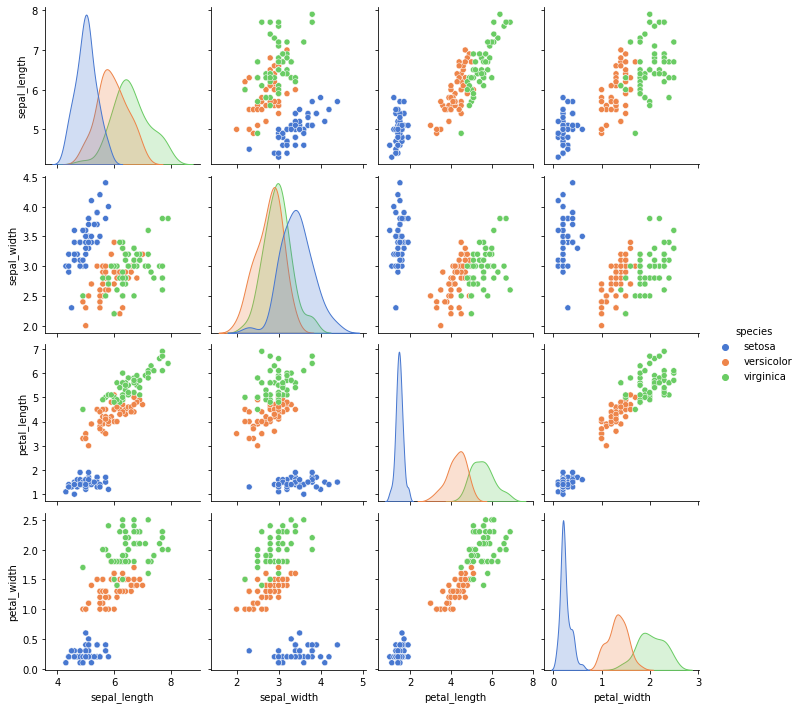

In [6]:
# plt.figure(figsize=(18, 14))
sns.pairplot(iris, hue='species', diag_kind='kde')

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes

x_n = 'sepal_length' 
x_0 = df[x_n].values

In [8]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)

    theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    # theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sampling.sample(5000, step=step, start=start, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8795124364932948, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

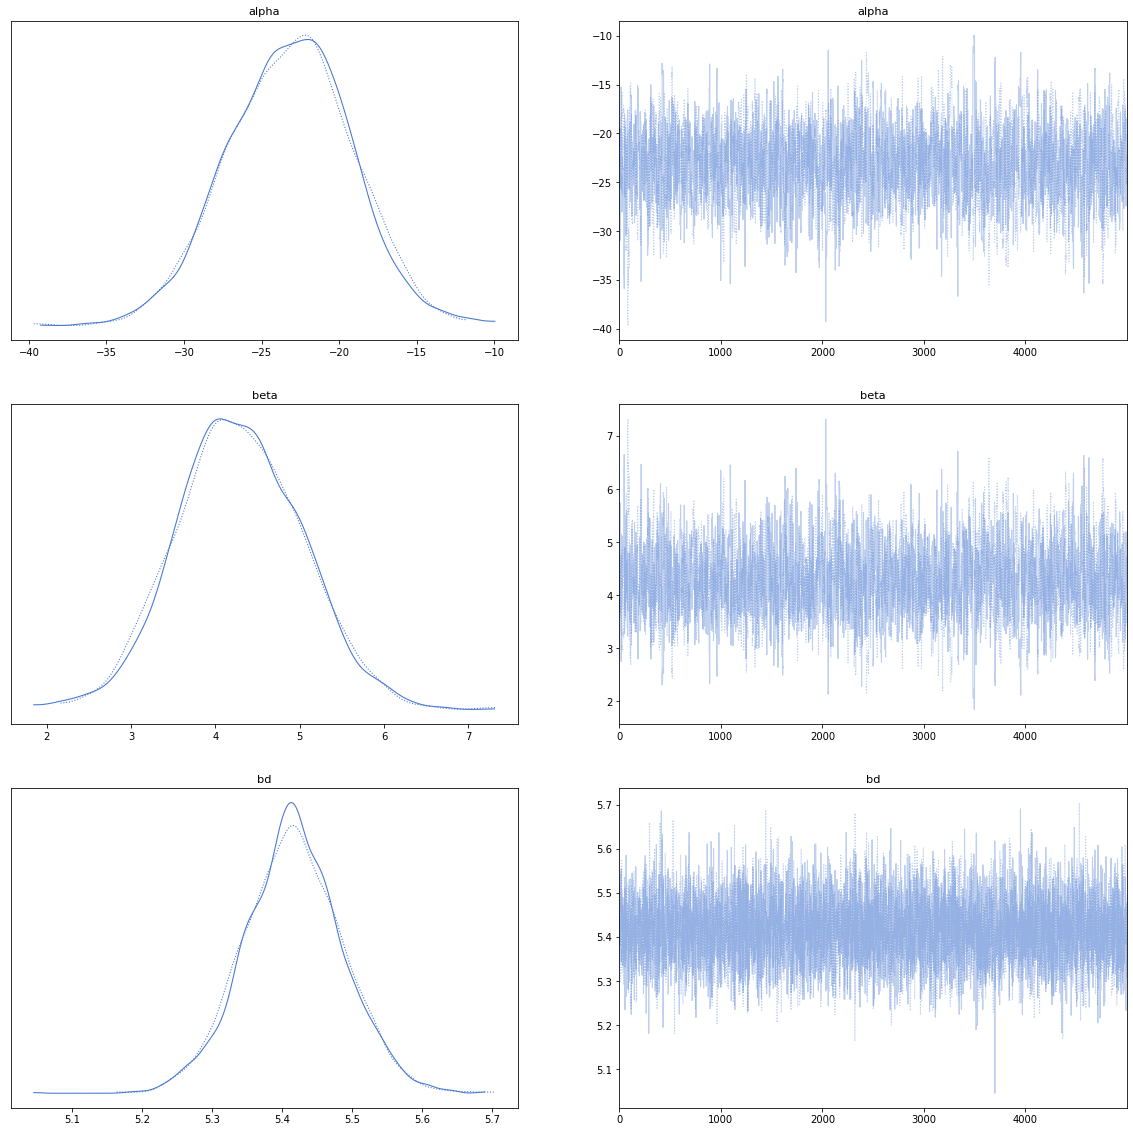

In [9]:
varnames = ['alpha', 'beta', 'bd']
pm.plot_trace(trace_0, varnames, figsize=(20, 20))

In [10]:
pm.summary(trace_0, varnames)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-23.21,4.00,-30.40,-15.53,1.12e-01,7.90e-02,1277.0,1289.0,1.0
beta,4.29,0.74,2.90,5.67,2.10e-02,1.50e-02,1276.0,1263.0,1.0
bd,5.42,0.07,5.29,5.55,1.00e-03,1.00e-03,7455.0,7294.0,1.0


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


Text(0, 0.5, '$\\theta$')

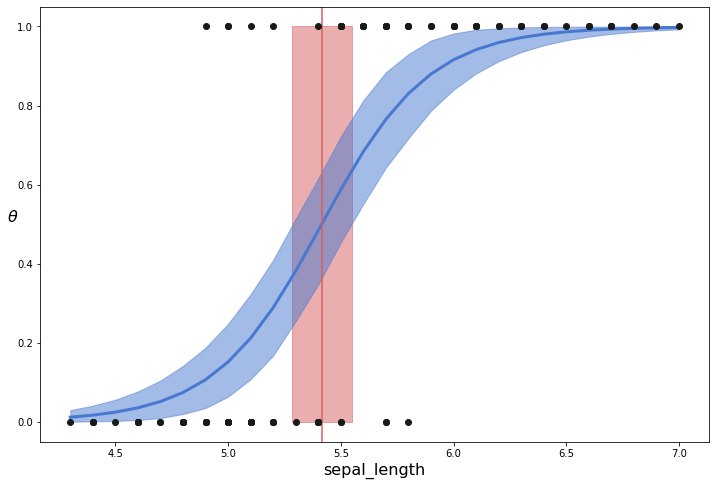

In [11]:
plt.figure(figsize=(12, 8))

theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)

plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')

bd_hpd = az.hdi(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

theta_hpd = az.hdi(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

In [12]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.14, 0.59, 0.92]), array([False,  True,  True]))

## Multiple logistic regression

In [13]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [14]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)

    # Sampling
    #start = pm.find_MAP()
    #step = pm.NUTS()
    #trace_1 = pm.sample(5000, step, start)

    trace_1 = pm.sampling.sample(5000, return_inferencedata=False)
    # trace_1 = pm.sampling.sample(5000, step=step, start=start, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 50 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

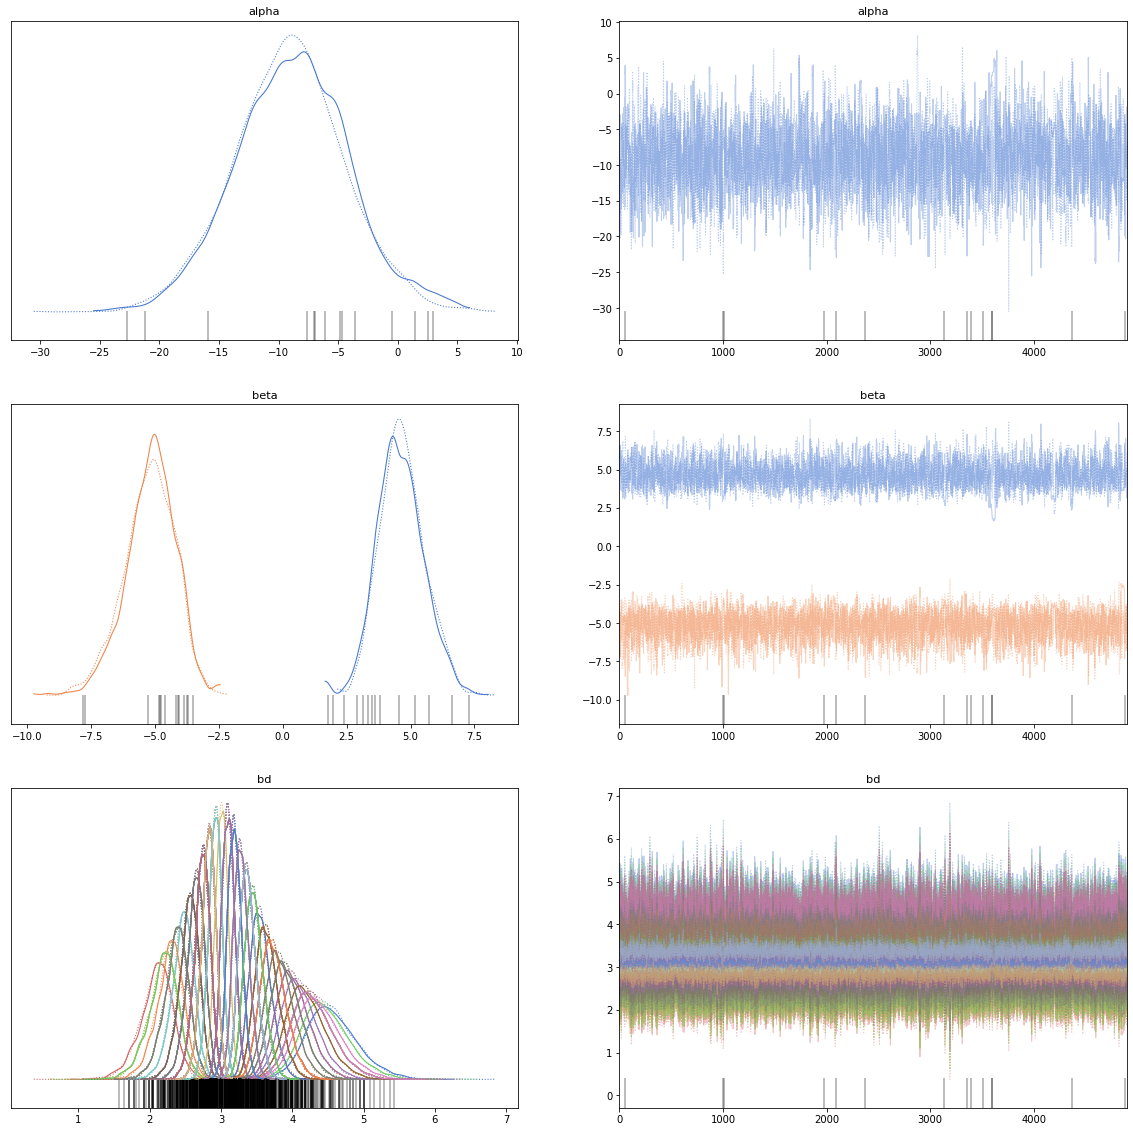

In [15]:
chain_1 = trace_1[100:]
pm.plot_trace(chain_1, figsize=(20, 20))

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  if __name__ == '__main__':


Text(0, 0.5, 'sepal_width')

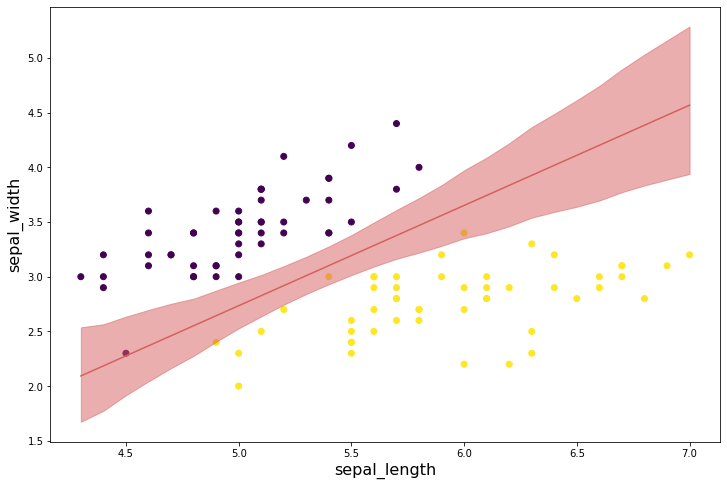

In [16]:
plt.figure(figsize=(12, 8))

idx = np.argsort(x_1[:, 0])
ld = chain_1['bd'].mean(0)[idx]

plt.scatter(x_1[:, 0], x_1[:, 1], c=y_0)
plt.plot(x_1[:, 0][idx], ld, color='r')

ld_hpd = az.hdi(chain_1['bd'])[idx]
plt.fill_between(x_1[:, 0][idx], ld_hpd[:, 0],
                 ld_hpd[:, 1], color='r', alpha=0.5)

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)


## correlated variables

<AxesSubplot:>

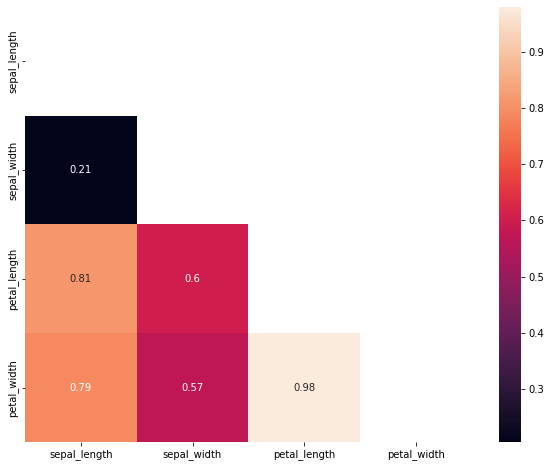

In [17]:
plt.figure(figsize=(10, 8))

corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True)


## unbalanced classes

In [18]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]  # df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)


In [19]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sampling.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 33 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

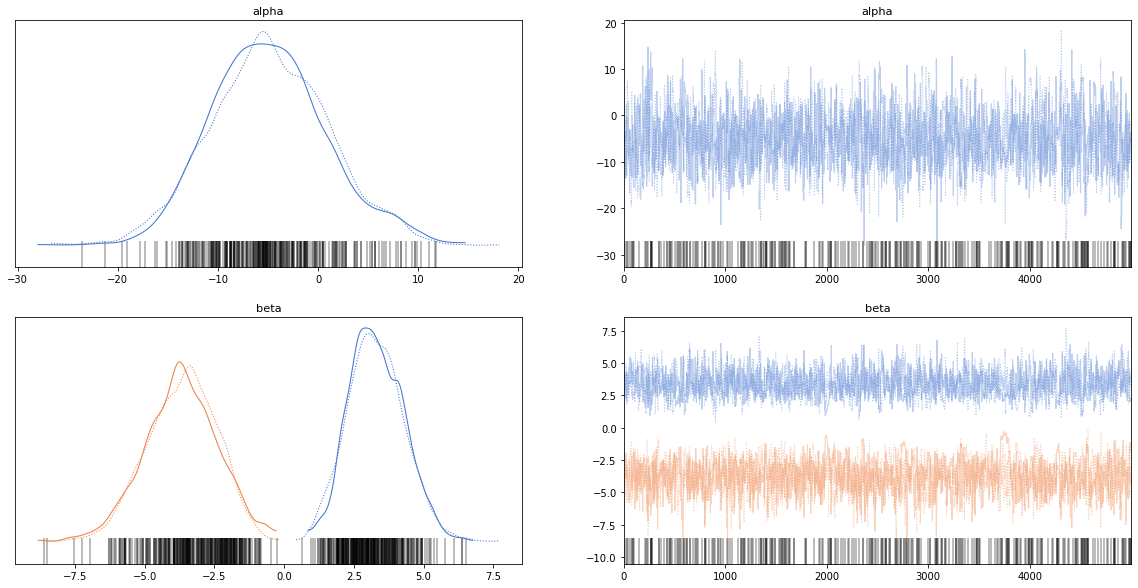

In [20]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.plot_trace(cadena_3, varnames, figsize=(20, 10))

In [21]:
pm.summary(cadena_3, varnames)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-4.85,5.86,-16.29,6.12,0.16,0.11,1332.0,1148.0,1.0
beta[0],3.31,1.00,1.54,5.27,0.03,0.02,1104.0,963.0,1.0
beta[1],-3.67,1.30,-6.19,-1.37,0.04,0.03,777.0,451.0,1.0


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  if __name__ == '__main__':


Text(0, 0.5, 'sepal_width')

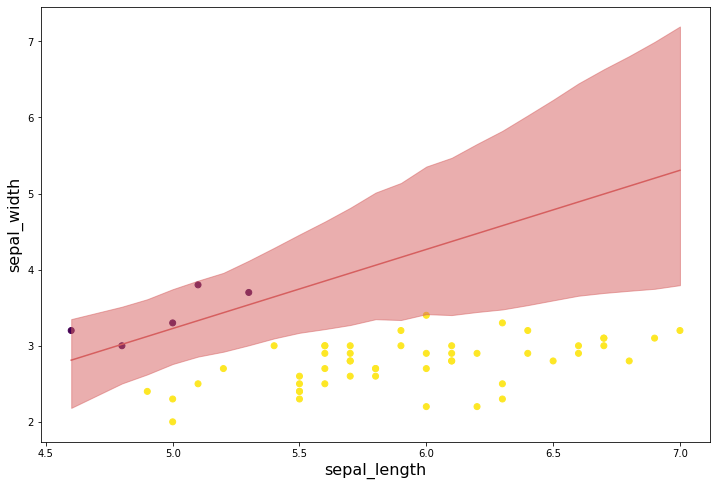

In [22]:
plt.figure(figsize=(12, 8))

idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]

plt.scatter(x_3[:,0], x_3[:,1], c=y_3)
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = az.hdi(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)


## Softmax regression or multinomial logistic regression

In [23]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [24]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    
    trace_s = pm.sampling.sample(2000, step=step, start=start, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 39 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

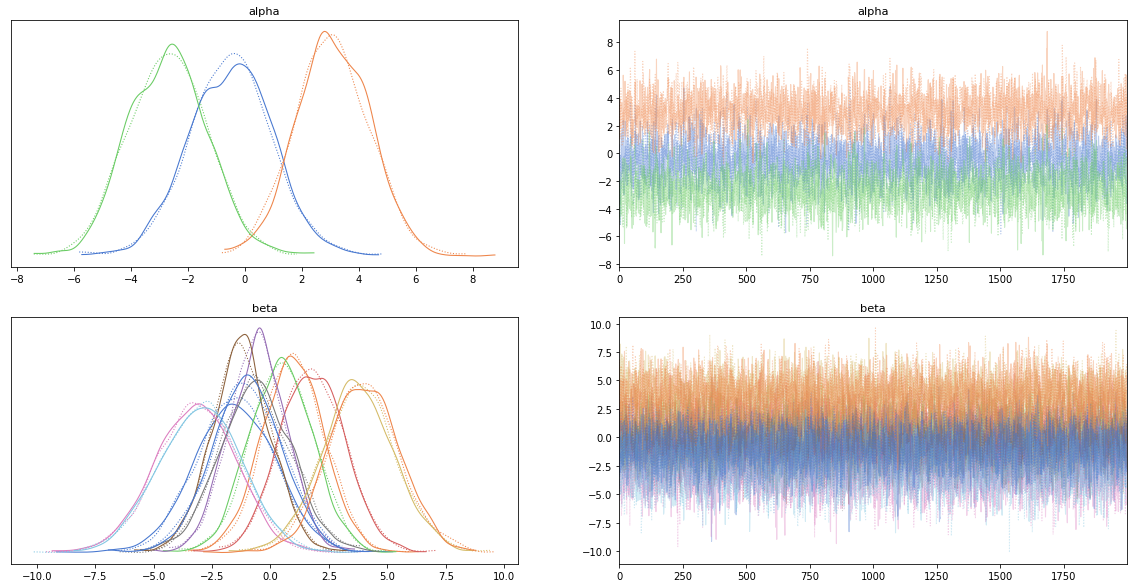

In [25]:
pm.plot_trace(trace_s, figsize=(20, 10))

In [26]:
pm.summary(trace_s)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.49,1.47,-3.17,2.30,0.03,0.02,3167.0,2825.0,1.0
alpha[1],3.09,1.29,0.58,5.42,0.03,0.02,2550.0,2820.0,1.0
alpha[2],-2.70,1.39,-5.36,-0.26,0.03,0.02,2782.0,2247.0,1.0
"beta[0, 0]",-1.50,1.68,-4.64,1.59,0.03,0.03,3394.0,2248.0,1.0
"beta[0, 1]",0.98,1.32,-1.57,3.40,0.03,0.02,2808.0,2667.0,1.0
"beta[0, 2]",0.47,1.34,-1.91,3.06,0.02,0.02,3145.0,2459.0,1.0
"beta[1, 0]",1.79,1.38,-0.79,4.33,0.03,0.02,2681.0,2464.0,1.0
"beta[1, 1]",-0.55,1.23,-2.79,1.76,0.03,0.02,2510.0,2573.0,1.0
"beta[1, 2]",-1.25,1.27,-3.66,1.08,0.03,0.02,2572.0,2462.0,1.0
"beta[2, 0]",-3.19,1.72,-6.37,0.04,0.03,0.02,3422.0,2604.0,1.0


In [27]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.9733333333333334

In [28]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    
    trace_sf = pm.sampling.sample(2000, step=step, start=start, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

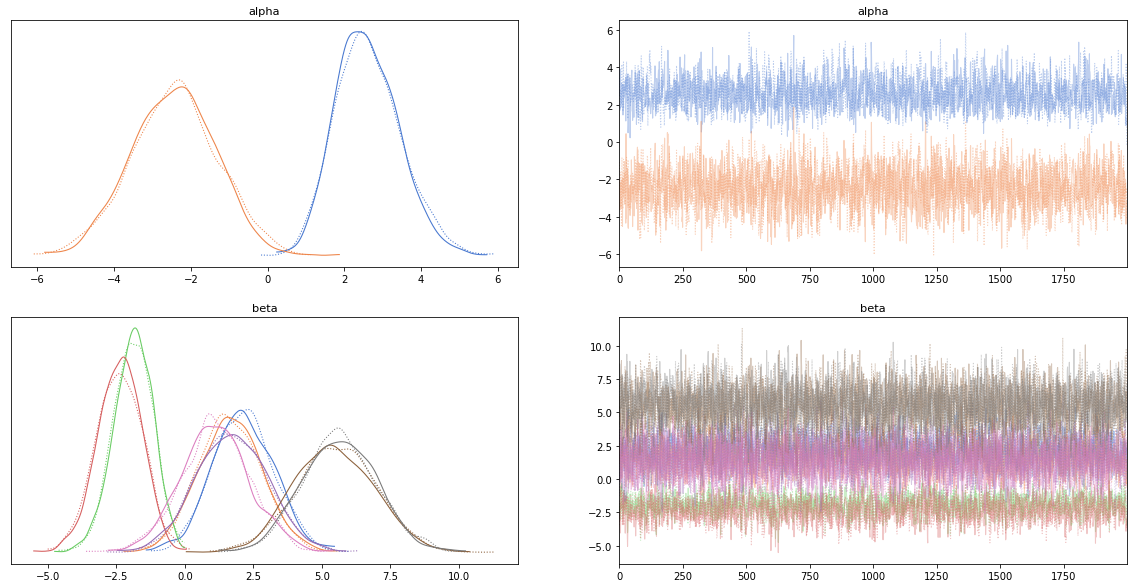

In [29]:
pm.plot_trace(trace_sf, figsize=(20, 10))

In [30]:
pm.summary(trace_sf)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.61,0.84,1.11,4.24,0.02,0.01,2077.0,2096.0,1.0
alpha[1],-2.43,1.11,-4.51,-0.33,0.02,0.02,2201.0,2243.0,1.0
"beta[0, 0]",2.13,1.12,0.05,4.24,0.03,0.02,1946.0,2026.0,1.0
"beta[0, 1]",1.66,1.16,-0.43,3.92,0.03,0.02,2058.0,2215.0,1.0
"beta[1, 0]",-1.90,0.72,-3.26,-0.58,0.02,0.01,1715.0,2251.0,1.0
"beta[1, 1]",-2.39,0.83,-3.95,-0.88,0.02,0.01,1886.0,2364.0,1.0
"beta[2, 0]",1.72,1.30,-0.72,4.16,0.03,0.02,2081.0,2369.0,1.0
"beta[2, 1]",5.49,1.47,2.69,8.13,0.03,0.02,2317.0,2611.0,1.0
"beta[3, 0]",1.11,1.27,-1.27,3.54,0.03,0.02,2228.0,2397.0,1.0
"beta[3, 1]",5.65,1.36,2.99,8.05,0.03,0.02,2056.0,2241.0,1.0


## linear discriminant analysis (LDA)

In [31]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [32]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    
    trace_lda = pm.sampling.sample(5000, step=step, start=start, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mus]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'mus'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

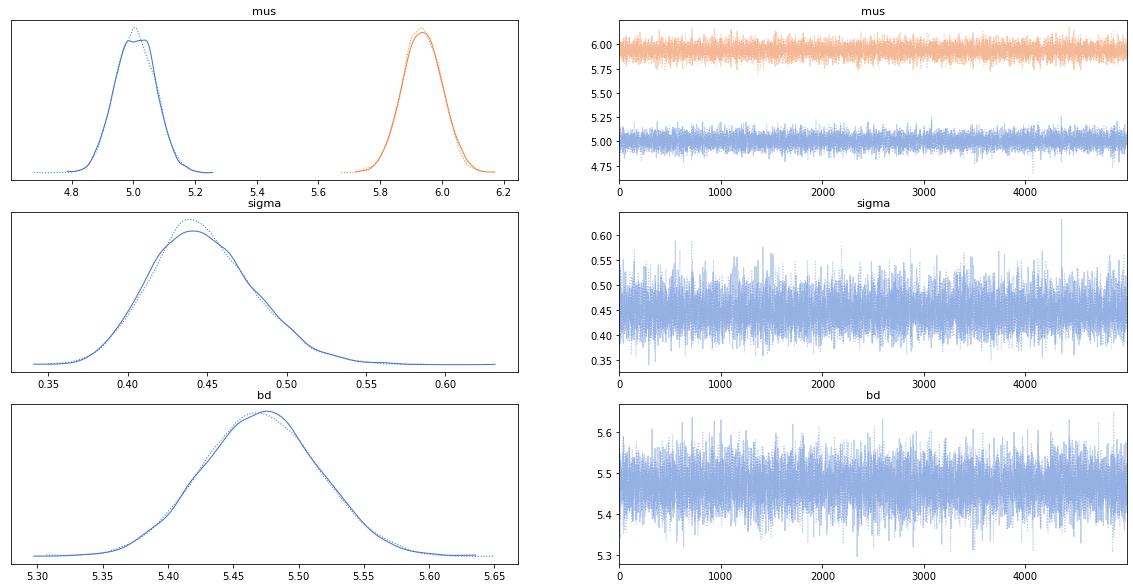

In [33]:
pm.plot_trace(trace_lda, figsize=(20, 10))

In [34]:
pm.summary(trace_lda)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mus[0],5.01,0.06,4.89,5.12,1.00e-03,0.0,12088.0,7246.0,1.0
mus[1],5.94,0.06,5.82,6.06,1.00e-03,0.0,13144.0,7263.0,1.0
sigma,0.45,0.03,0.39,0.51,0.00e+00,0.0,12874.0,7561.0,1.0
bd,5.47,0.04,5.38,5.55,0.00e+00,0.0,12289.0,7132.0,1.0


Text(0.5, 0, 'sepal_length')

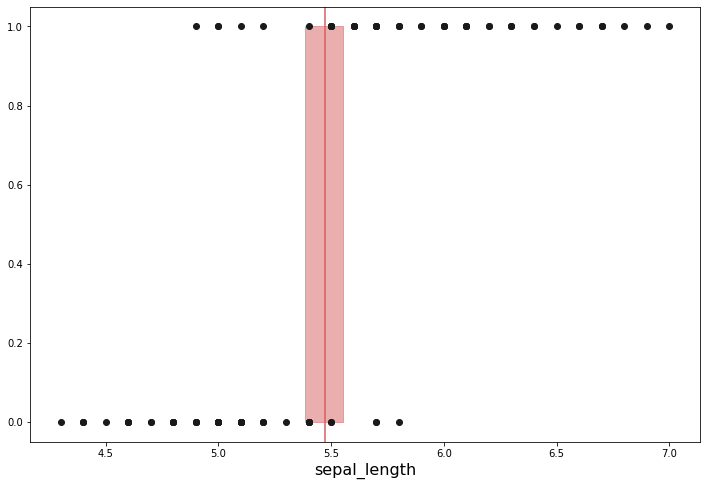

In [35]:
plt.figure(figsize=(12, 8))

plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')

bd_hpd = az.hdi(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)